# 0. IMPORTS

In [1]:
#data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot   as plt
import seaborn as sns

#data preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn               import model_selection as ms


#machine learning algorithms
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LogisticRegression,SGDClassifier
from sklearn.ensemble        import RandomForestClassifier,ExtraTreesClassifier,IsolationForest
from sklearn.svm             import SVC

#metrics
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from sklearn.metrics         import classification_report,confusion_matrix,accuracy_score, roc_curve, auc
from scikitplot              import metrics      as mt

#feature selection
from boruta                import BorutaPy


from IPython.display       import HTML
from IPython.display       import Image


#auxiliar packages
import pickle
import warnings
import inflection


## 0.1. Helper Functions

In [2]:
pd.set_option('float_format', '{:.3f}'.format)



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()
    

In [3]:
jupyter_settings()
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
data_raw = pd.read_csv('/home/rafael/Repos/fraud_detection/data/data_fraud.csv')

In [5]:
data_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


In [6]:
data_raw.shape

(6362620, 11)

In [7]:
data_raw['type'].value_counts(normalize=True)

CASH_OUT   0.352
PAYMENT    0.338
CASH_IN    0.220
TRANSFER   0.084
DEBIT      0.007
Name: type, dtype: float64

## 0.3 Data Sampling

In [8]:
#data_raw_is_fraud
data_raw_fraud = data_raw[data_raw['isFraud'] == 1]

#data_raw_not_fraud
data_raw_not_fraud = data_raw[data_raw['isFraud'] == 0].sample(1000000)

#concat data
data_raw_sample = pd.concat([data_raw_fraud,data_raw_not_fraud], axis = 0)

In [9]:
data_raw_sample.reset_index(drop = True).head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
1,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
2,1,TRANSFER,2806.000,C1420196421,2806.000,0.000,C972765878,0.000,0.000,1,0
3,1,CASH_OUT,2806.000,C2101527076,2806.000,0.000,C1007251739,26202.000,0.000,1,0
4,1,TRANSFER,20128.000,C137533655,20128.000,0.000,C1848415041,0.000,0.000,1,0


# 1. DATA DESCRIPTION

In [10]:
df1 = data_raw_sample.copy()

* **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
* **amount** - amount of the transaction in local currency.
* **nameOrig** - customer who started the transaction
* **oldbalanceOrg** - initial balance before the transaction
* **newbalanceOrig** - new balance after the transaction
* **nameDest** - customer who is the recipient of the transaction
* **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
* **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



## 1.1. Rename Columns

In [11]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [12]:
# df1.columns

cols_old = ['step', 'paymentType', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']

#snakecase = lambda x: x.lower()
snakecase = lambda x: inflection.underscore(x)

cols_new = list((map(snakecase,cols_old)))

# rename
df1.columns = cols_new
df1.columns

Index(['step', 'payment_type', 'amount', 'name_orig', 'oldbalance_orig',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.1. Data Dimensions


In [13]:
print('Number of rows: {}'. format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1008213
Number of columns: 11


In [14]:
df1['payment_type'].value_counts(normalize=True)

CASH_OUT   0.353
PAYMENT    0.336
CASH_IN    0.218
TRANSFER   0.087
DEBIT      0.006
Name: payment_type, dtype: float64


## 1.2. Data Types


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1008213 entries, 2 to 2458989
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              1008213 non-null  int64  
 1   payment_type      1008213 non-null  object 
 2   amount            1008213 non-null  float64
 3   name_orig         1008213 non-null  object 
 4   oldbalance_orig   1008213 non-null  float64
 5   newbalance_orig   1008213 non-null  float64
 6   name_dest         1008213 non-null  object 
 7   oldbalance_dest   1008213 non-null  float64
 8   newbalance_dest   1008213 non-null  float64
 9   is_fraud          1008213 non-null  int64  
 10  is_flagged_fraud  1008213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 92.3+ MB


## 1.3. Check NA

In [16]:
df1.isna().sum()

step                0
payment_type        0
amount              0
name_orig           0
oldbalance_orig     0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64


## 1.4. Variable Response


In [17]:
df1['is_fraud'].value_counts(normalize = True)

0   0.992
1   0.008
Name: is_fraud, dtype: float64

## 1.5 Descriptive Statistical Analysis

In [18]:
num_attributes = df1.select_dtypes( include = ('int64','float64'))
cat_attributes = df1.select_dtypes( exclude = ('int64','float64'))
num_attributes.sample(2)

,step,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
1377717,138,87931.790,2246.000,90177.790,1315736.660,1227804.870,0,0
5486586,380,174331.830,35242.000,0.000,0.000,174331.830,0,0


### 1.5.1. Numerical Attributes

In [19]:
num_attributes.describe().T.drop(columns = 'count')

,mean,std,min,25%,50%,75%,max
step,244.140,143.353,1.000,156.000,240.000,336.000,743.000
amount,189158.234,648552.003,0.000,13541.110,75963.460,211028.350,69337316.270
oldbalance_orig,839042.362,2899164.411,0.000,0.000,14819.000,111256.000,59585040.370
newbalance_orig,850045.192,2924146.016,0.000,0.000,0.000,142010.750,49585040.370
oldbalance_dest,1096558.806,3368381.336,0.000,0.000,129308.880,936861.500,355185537.060
newbalance_dest,1225557.321,3661112.507,0.000,0.000,213941.020,1111238.000,355380483.530
is_fraud,0.008,0.090,0.000,0.000,0.000,0.000,1.000
is_flagged_fraud,0.000,0.004,0.000,0.000,0.000,0.000,1.000


**Descriptive Analysis Summary**

*Balance*
* None of the balances have negative numbers 
* The initial balance before the transaction (oldbalance_orig) ranges from 0 to aprox 59 mi. Mean = 839,042.7. **25% of the observations are equal to 0**. 75% of the observations are up to the value of 111,256
* The initial balance after the transaction (newbalance_orig) ranges from 0 to aprox 49.5 mi. Mean = 850,045. **50% of the observations are equal to 0**. 75% of the observations are up to the value of 142,010


* The initial balance recipient before the transaction (oldbalance_dest) ranges from 0 to more than 355 Million. Mean = 1,096,558. 25% of the observations are equal to zero. 75% of the observations are up to the value of 936,861
* The new balance recipient after the transaction (newbalance_dest) ranges from zero to more than 355 Million. Mean = 1,225,557. **25% of the observations are equal to zero** - it can be either from merchant or from fraudulent agent behaviour (cashing out of the system). 75% of the observations are up to the value of 1,111,238



*Transaction Amount*
* Transaction amount ranges from 0 to more than 69 mi, Mean = 189,158. The minimum value is equal to zero.


# 2.0. FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1. Account Type

In [21]:
account_type_or = df2['name_orig'].astype(str)
account_type_or_init = account_type_or.str[:1]
account_type_or_init.unique()

array(['C'], dtype=object)

In [22]:
account_type_dest = df2['name_dest'].astype(str)
account_type_dest_init = account_type_dest.str[:1]
account_type_dest_init.unique()

array(['C', 'M'], dtype=object)

In [23]:
#client
df2['client_orig'] = df2['name_orig'].apply(lambda x: 'M' if "M" in x else "C")
df2['client_dest'] = df2['name_dest'].apply(lambda x: "M" if "M" in x else "C")

#type
df2["transaction_type"] = np.nan # initializing feature column

# filling feature column
df2.loc[df2.client_orig.str.contains('C') & df2.client_orig.str.contains('C'),"transaction_type"] = "CC" 
df2.loc[df2.client_orig.str.contains('C') & df2.client_dest.str.contains('M'),"transaction_type"] = "CM"

## 2.2. Account Balance

In [24]:
#checking orig and dest account balance before and after transaction
origin_check = ( df2['newbalance_orig'] - df2['amount'] ) == df2['oldbalance_orig']
print('{} of all origin balance values are correct'.format(round((origin_check.sum()/len(df2))*100,2)))

14.49 of all origin balance values are correct


In [25]:
dest_check = ( df2['oldbalance_dest'] + df2['amount'] ) == df2['newbalance_dest']
print('{} of all destination balance values are correct'.format(round((dest_check.sum()/len(df2))*100,2)))

25.64 of all destination balance values are correct


**Hypothesis**: Negative values are not recorded

In [26]:
negative = df2.loc[df2["oldbalance_orig"]<0].values
negative

array([], shape=(0, 14), dtype=object)

In [27]:
num_amt_oldorig = sum(df2["amount"] > df2["oldbalance_orig"]) / len(df2)
num_amt_oldorig

0.6370985099378802

In [28]:
#Adjusted account balance
df2['adjusted_newbalance_orig'] = df2['oldbalance_orig'] - df2['amount'] 
df2['adjusted_newbalance_dest'] = df2['oldbalance_dest'] + df2['amount'] 

#error account balance
df2['error_balance_orig'] = df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_orig']
df2['error_balance_dest'] = df2['newbalance_dest'] + df2['amount'] - df2['oldbalance_dest']

## 2.3. Flagged Transactions

In [29]:
flagged = df2[df2["is_flagged_fraud"] == 1]
flagged_correctly = sum(flagged["is_fraud"] == 1)
print('Number of transactions flagged correctly: {}'.format(flagged_correctly))
print('Number of fraudulent transactions: {}'.format(df2['is_fraud'].value_counts()[1]))

Number of transactions flagged correctly: 16
Number of fraudulent transactions: 8213


## 2.4. Step - Day

In [30]:
df2['day'] = df2['step'].apply(lambda x: int(x/24))

In [31]:
df2.head()

,step,payment_type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,client_orig,client_dest,transaction_type,adjusted_newbalance_orig,adjusted_newbalance_dest,error_balance_orig,error_balance_dest,day
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0,C,C,CC,0.000,181.000,0.000,181.000,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0,C,C,CC,0.000,21363.000,0.000,-21001.000,0
251,1,TRANSFER,2806.000,C1420196421,2806.000,0.000,C972765878,0.000,0.000,1,0,C,C,CC,0.000,2806.000,0.000,2806.000,0
252,1,CASH_OUT,2806.000,C2101527076,2806.000,0.000,C1007251739,26202.000,0.000,1,0,C,C,CC,0.000,29008.000,0.000,-23396.000,0
680,1,TRANSFER,20128.000,C137533655,20128.000,0.000,C1848415041,0.000,0.000,1,0,C,C,CC,0.000,20128.000,0.000,20128.000,0


# 3.0. FILTERED VARIABLES

In [32]:
df3 = df2.copy()

In [33]:
## 3.1. Filtered Columns
cols_drop = ['client_orig','client_dest','name_dest','name_orig','is_flagged_fraud']
df3 = df3.drop(cols_drop, axis=1)


# 4.0. EXPLORATORY DATA ANALYSIS

In [34]:
df4 = df3.copy()

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
aux_1 = df4[df4['is_fraud'] == 1]
sns.scatterplot(x = 'day', y = 'newbalance_orig', data = aux_1)

plt.subplot(1,3,2)
aux_0 = df4[df4['is_fraud'] == 0]
sns.scatterplot(x = 'day', y = 'newbalance_orig', data = aux_0)

plt.subplot(1,3,3)
point_bi(df4[['is_fraud']],df4[['newbalance_orig']])

# 5.0. DATA PREPARATION

In [35]:
df5 = df4.copy()

In [36]:
# Test Dataset Extraction
X = df5.drop('is_fraud', axis = 1).copy()
y = df5['is_fraud'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 45)

# df_test is a separate dataset, and will be used to perform the final evaluation of the trained model
df_test = pd.concat([x_test, y_test], axis = 1)

## 5.1. Numerical variables rescaling

Check the presence of outliers in order to choose the best technique for our model. The techniques that will be used:

*  *RobustScaler*-> Robust in the presence of outliers, therefore, in the variables that have a significant amount of outliers we will apply this technique.

*  *MinMaxScaler* -> Sensitive in the presence of outliers, therefore, we will apply to our variables that do not have outliers.



In [37]:
num_attributes = x_train.select_dtypes(exclude = 'object')
num_attributes

,step,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,adjusted_newbalance_orig,adjusted_newbalance_dest,error_balance_orig,error_balance_dest,day
2063729,181,38913.600,0.000,0.000,0.000,0.000,-38913.600,38913.600,38913.600,38913.600,7
5247746,371,180464.110,387.000,0.000,0.000,180464.110,-180077.110,180464.110,180077.110,360928.220,15
2659260,210,5726.170,13211.000,7484.830,0.000,0.000,7484.830,5726.170,0.000,5726.170,8
5624435,395,254254.210,7124833.470,7379087.680,3967427.550,3713173.340,6870579.260,4221681.760,508508.420,0.000,16
2357276,190,6596.110,166772.000,160175.890,0.000,0.000,160175.890,6596.110,0.000,6596.110,7
...,...,...,...,...,...,...,...,...,...,...,...
5041226,354,18424.730,13474.190,0.000,0.000,0.000,-4950.540,18424.730,4950.540,18424.730,14
5475436,379,563166.330,0.000,0.000,8417794.330,8980960.670,-563166.330,8980960.660,563166.330,1126332.670,15
5682120,397,90114.970,0.000,0.000,913879.890,1003994.860,-90114.970,1003994.860,90114.970,180229.940,16
1451556,140,8644.330,194337.000,185692.670,0.000,0.000,185692.670,8644.330,0.000,8644.330,5


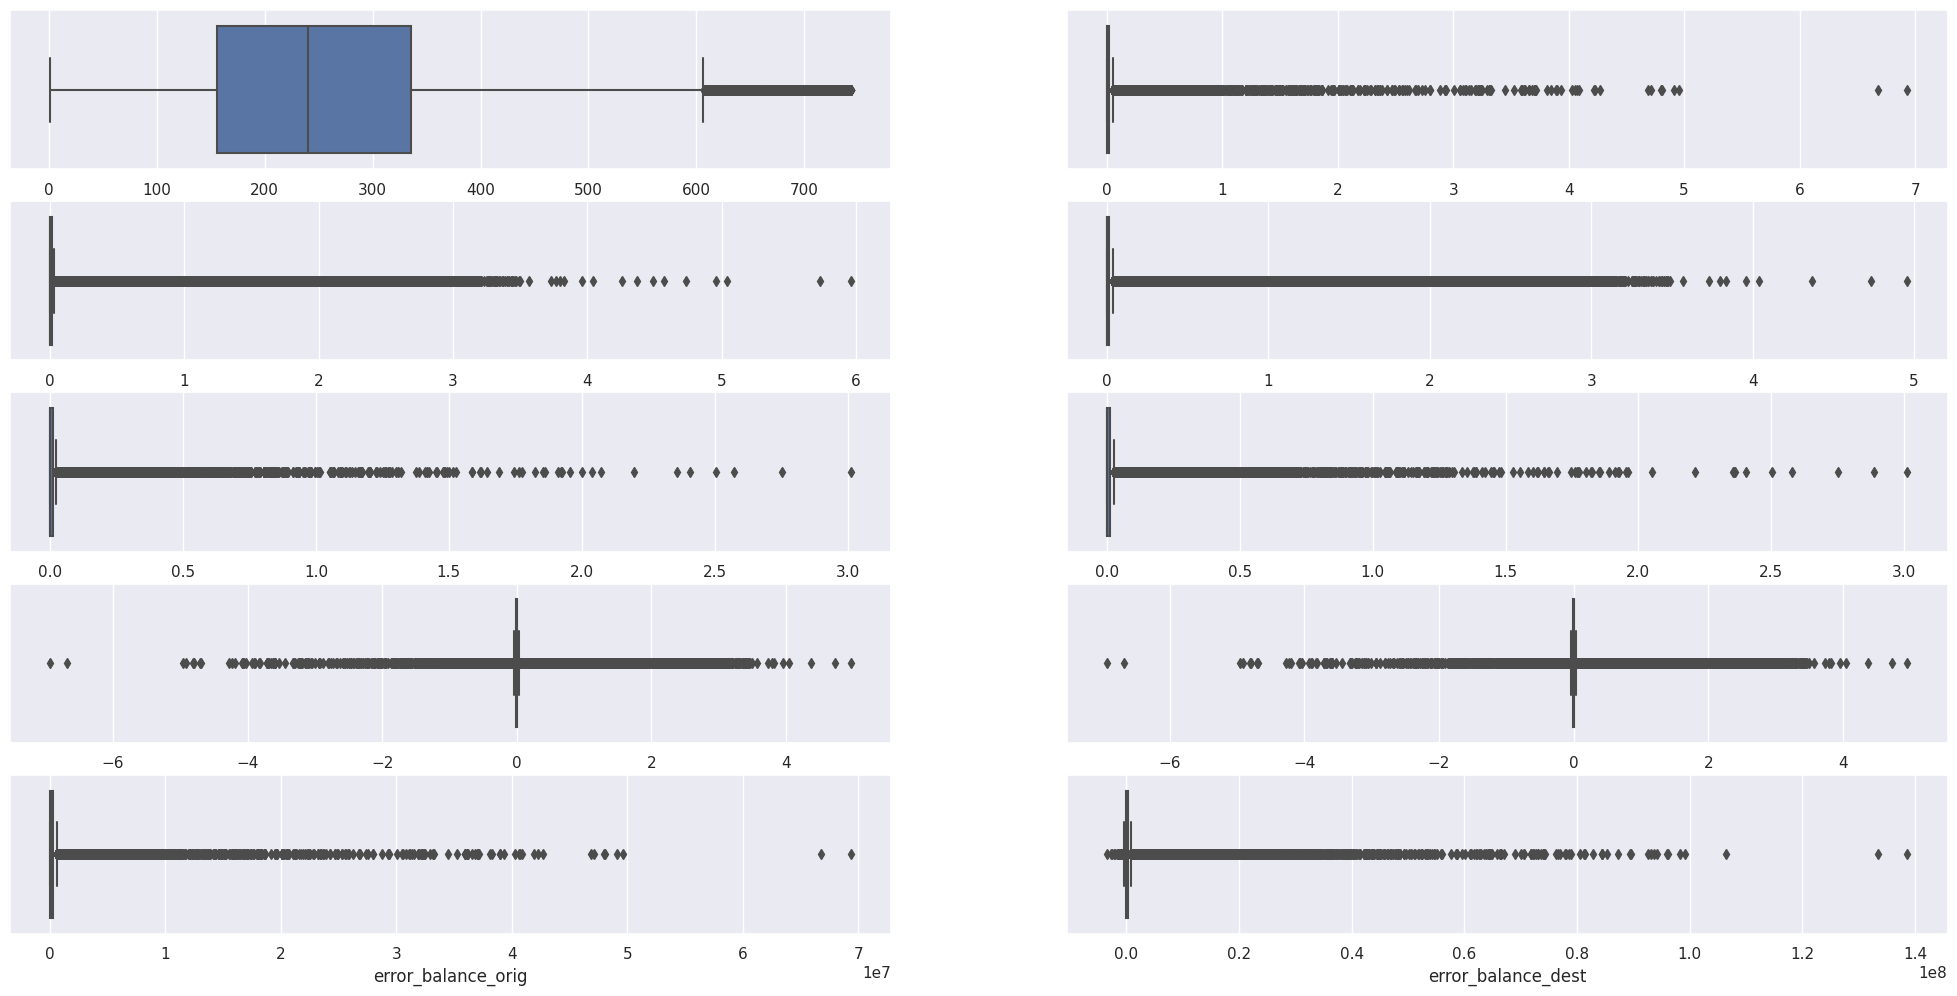

In [38]:
plt.subplot(5,2,1)
sns.boxplot(x = x_train['step'])

plt.subplot(5,2,2)
sns.boxplot(x = x_train['amount'])

plt.subplot(5,2,3)
sns.boxplot(x = x_train['oldbalance_orig'])

plt.subplot(5,2,4)
sns.boxplot(x = x_train['newbalance_orig'])

plt.subplot(5,2,5)
sns.boxplot(x = x_train['oldbalance_dest'])

plt.subplot(5,2,6)
sns.boxplot(x = x_train['newbalance_dest'])

plt.subplot(5,2,7)
sns.boxplot(x = x_train['adjusted_newbalance_orig'])

plt.subplot(5,2,8)
sns.boxplot(x = x_train['adjusted_newbalance_orig'])

plt.subplot(5,2,9)
sns.boxplot(x = x_train['error_balance_orig'])

plt.subplot(5,2,10)
sns.boxplot(x = x_train['error_balance_dest']);

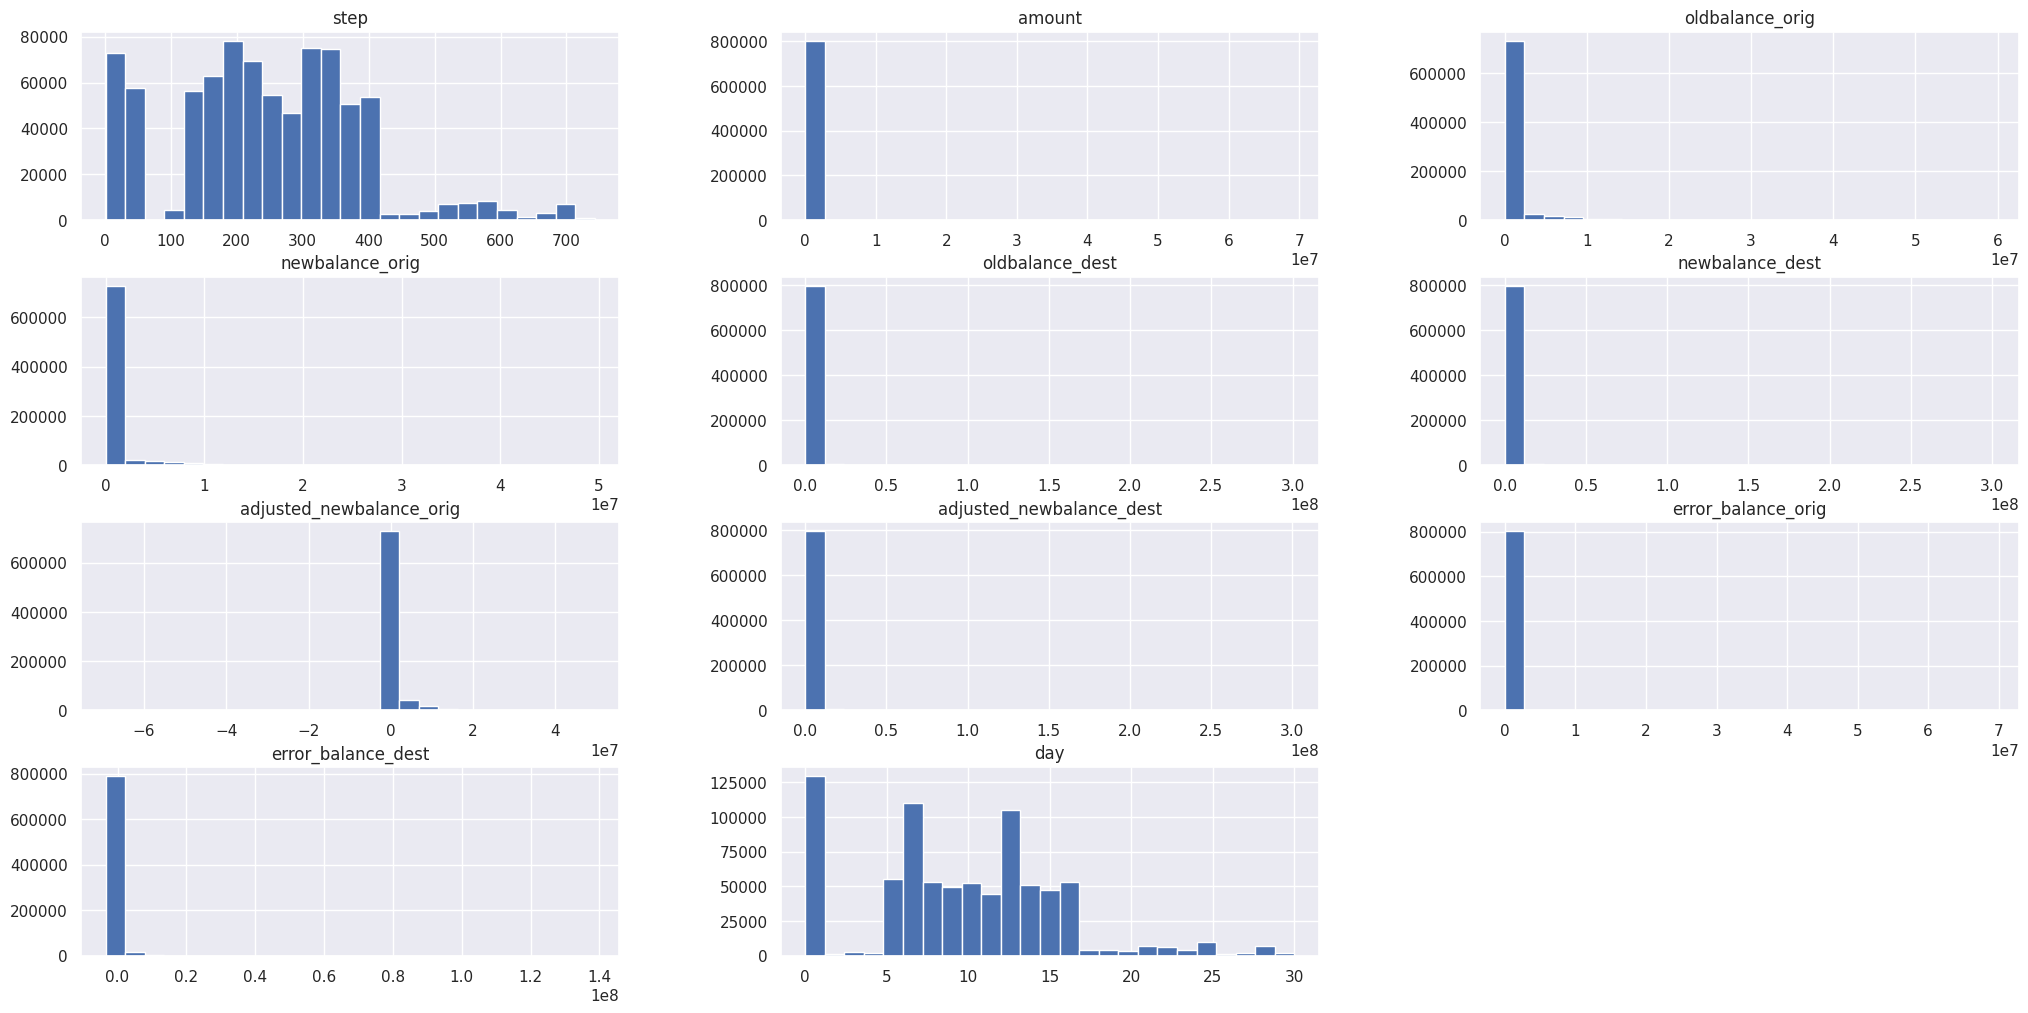

In [39]:
num_attributes.hist(bins = 25);

Normallization is a method of scaling applied to variables presenting a normal distribution. It is noted that there is no normal distribution. Therefore, normalization (which would be centered on 0 and adjust the standard deviation to 1) will not be applied to any data series.


In [40]:
x_train.head()

,step,payment_type,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,transaction_type,adjusted_newbalance_orig,adjusted_newbalance_dest,error_balance_orig,error_balance_dest,day
2063729,181,PAYMENT,38913.600,0.000,0.000,0.000,0.000,CM,-38913.600,38913.600,38913.600,38913.600,7
5247746,371,CASH_OUT,180464.110,387.000,0.000,0.000,180464.110,CC,-180077.110,180464.110,180077.110,360928.220,15
2659260,210,PAYMENT,5726.170,13211.000,7484.830,0.000,0.000,CM,7484.830,5726.170,0.000,5726.170,8
5624435,395,CASH_IN,254254.210,7124833.470,7379087.680,3967427.550,3713173.340,CC,6870579.260,4221681.760,508508.420,0.000,16
2357276,190,PAYMENT,6596.110,166772.000,160175.890,0.000,0.000,CM,160175.890,6596.110,0.000,6596.110,7


In [41]:
#define models
rs_amount = RobustScaler()
rs_oldbalance_orig = RobustScaler()
rs_newbalance_orig = RobustScaler()
rs_oldbalance_dest = RobustScaler()
rs_newbalance_dest = RobustScaler()
rs_adjusted_newbalance_orig = RobustScaler()
rs_adjusted_newbalance_dest = RobustScaler()
rs_error_balance_orig = RobustScaler()
rs_error_balance_dest = RobustScaler()
mms_step = MinMaxScaler()
mms_day = MinMaxScaler()

#RobustScaler
x_train['amount'] = rs_amount.fit_transform(x_train[['amount']].values)

x_train['oldbalance_orig'] = rs_oldbalance_orig.fit_transform(x_train[['oldbalance_orig']].values)

x_train['newbalance_orig'] = rs_newbalance_orig.fit_transform(x_train[['newbalance_orig']].values)

x_train['oldbalance_dest'] = rs_oldbalance_dest.fit_transform(x_train[['oldbalance_dest']].values)

x_train['newbalance_dest'] = rs_newbalance_dest.fit_transform(x_train[['newbalance_dest']].values)

x_train['adjusted_newbalance_orig'] = rs_adjusted_newbalance_orig.fit_transform(x_train[['adjusted_newbalance_orig']].values)

x_train['adjusted_newbalance_dest'] = rs_adjusted_newbalance_dest.fit_transform(x_train[['adjusted_newbalance_dest']].values)

x_train['error_balance_orig'] = rs_error_balance_orig.fit_transform(x_train[['error_balance_orig']].values)

x_train['error_balance_dest'] = rs_error_balance_dest.fit_transform(x_train[['error_balance_dest']].values)


#MinMaxScaler
x_train['step'] = mms_step.fit_transform(x_train[['step']].values)

x_train['day'] = mms_day.fit_transform(x_train[['day']].values)

## 5.2. Features encoding

In [42]:
# payment type - Label Encoding
le_payment_type = LabelEncoder()

x_train['payment_type'] = le_payment_type.fit_transform(x_train['payment_type'])

# transaction type - Ordinal Encoding
transaction_dict = {'CC': 1,
                   'CM': 2}
x_train['transaction_type'] = x_train['transaction_type'].map(transaction_dict)

## 5.2. Test Preparation

Replicate the transformation done in training(df) to x_test dataset.


In [43]:
# applies same training encoders to testing data

x_test.loc[:, 'amount'] = rs_amount.transform(x_test[['amount']].values)

x_test.loc[:, 'oldbalance_orig'] = rs_oldbalance_orig.transform(x_test[['oldbalance_orig']].values)

x_test.loc[:, 'newbalance_orig'] = rs_newbalance_orig.transform(x_test[['newbalance_orig']].values)

x_test.loc[:, 'oldbalance_dest'] = rs_oldbalance_dest.transform(x_test[['oldbalance_dest']].values)

x_test.loc[:, 'newbalance_dest'] = rs_newbalance_dest.transform(x_test[['newbalance_dest']].values)

x_test.loc[:, 'adjusted_newbalance_orig'] = rs_adjusted_newbalance_orig.transform(x_test[['adjusted_newbalance_orig']].values)

x_test.loc[:, 'adjusted_newbalance_dest'] = rs_adjusted_newbalance_dest.transform(x_test[['adjusted_newbalance_dest']].values)

x_test.loc[:, 'error_balance_orig'] = rs_error_balance_orig.transform(x_test[['error_balance_orig']].values)

x_test.loc[:, 'error_balance_dest'] = rs_error_balance_dest.transform(x_test[['error_balance_dest']].values)



x_test.loc[:, 'step'] = mms_step.transform(x_test[['step']].values)

x_test.loc[:, 'day'] = mms_day.transform(x_test[['day']].values)


x_test.loc[:, 'payment_type'] = le_payment_type.transform(x_test[['payment_type']].values)

x_test['transaction_type'] = x_test['transaction_type'].map(transaction_dict)

In [44]:
x_test

,step,payment_type,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,transaction_type,adjusted_newbalance_orig,adjusted_newbalance_dest,error_balance_orig,error_balance_dest,day
1345222,0.183,3,-0.266,6.323,4.885,-0.138,-0.192,2,3.653,-0.245,-0.271,-0.017,0.167
1251751,0.179,3,-0.157,-0.133,0.000,-0.138,-0.192,2,-0.160,-0.227,-0.087,0.052,0.167
3981707,0.400,1,0.150,-0.081,0.000,-0.138,-0.097,1,-0.444,-0.176,0.136,0.589,0.400
4840207,0.466,4,6.847,0.016,0.000,7.579,7.598,1,-7.237,6.997,5.481,9.127,0.467
2061406,0.243,1,0.455,-0.037,0.000,6.278,5.365,1,-0.731,4.916,0.362,0.978,0.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281432,0.337,3,-0.260,0.562,0.370,-0.138,-0.192,2,0.344,-0.244,-0.271,-0.013,0.333
368491,0.022,1,0.108,-0.133,0.000,0.038,0.044,1,-0.431,-0.045,0.126,0.536,0.000
6205144,0.788,1,0.486,-0.133,0.000,0.119,0.179,1,-0.817,0.081,0.430,1.017,0.800
819879,0.053,1,0.101,-0.133,0.000,0.719,0.616,1,-0.423,0.489,0.120,0.526,0.033


In [45]:
x_test.isna().sum()

step                        0
payment_type                0
amount                      0
oldbalance_orig             0
newbalance_orig             0
oldbalance_dest             0
newbalance_dest             0
transaction_type            0
adjusted_newbalance_orig    0
adjusted_newbalance_dest    0
error_balance_orig          0
error_balance_dest          0
day                         0
dtype: int64

# 6.0. FEATURE SELECTION

## 6.1. Boruta as Feature Selector

In [46]:
#split data
X = x_train
y = y_train

In [47]:
y

2063729    0
5247746    0
2659260    0
5624435    0
2357276    0
          ..
5041226    0
5475436    0
5682120    0
1451556    0
4388767    1
Name: is_fraud, Length: 806570, dtype: int64

In [48]:
# #define model
# rf = RandomForestRegressor( n_jobs=-1 )


# #split data 
# X_train_nn = X.values
# y_train_nn = y.values.ravel()

# #define boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_nn, y_train_nn )

In [49]:
# After running Boruta
# columns selected boruta

# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta = [
    'step',
    'amount',
    'oldbalance_orig',
    'newbalance_orig',
    'adjusted_newbalance_orig',
    'error_balance_orig']

In [50]:
# columns not selected 
# cols_not_selected_boruta = list( np.setdiff1d( X.columns,cols_selected_boruta ) )

cols_not_selected_boruta = [
    'adjusted_newbalance_dest',
    'day',
    'error_balance_dest',
    'newbalance_dest',
    'oldbalance_dest',
    'payment_type',
    'transaction_type']

## 6.3. Manual Feature Selection

Important features taking into consideration Boruta Selection

In [51]:
# columns not selected 

cols_selected_boruta_full = [
    'step',
    'amount',
    'oldbalance_orig',
    'newbalance_orig',
    'adjusted_newbalance_orig',
    'error_balance_orig',
    'adjusted_newbalance_dest',
    'error_balance_dest']




# 7.0. MACHINE LEARNING MODELLING


Model Evaluation in Credit Card Fraud Detection

* Accuracy isn't everything. When working with highly imbalanced data, accuracy is not a reliable performance metric. Because by doing nothing but just predicting everything is in the maority class, you can obtain a higher accuracy than by building a predictive model.
* Precision: true positives / (true positives + false positives)
* Recall : true positives / (true positives +false negatives)
* F1-score: 2 x Precision x Recall / (Precision + Recall) = 2 x TP / (2 x TP + FP + FN)
* A credit card company wants to watch as much fraud as possible(reduce false negatives) as fraudulent transactios can be very costly and a false alarm means someone's transaction is blocked(reduce false positives).

In [52]:
x_train = x_train[cols_selected_boruta_full]
x_test = x_test[cols_selected_boruta_full]

## 7.1. Logistic Regression


Logistic regression is a calculation used to predict a binary outcome: either something happens, or does not. This can be exhibited as Yes/No, Pass/Fail, Alive/Dead, etc. In this case, the goal is to identify whether a transaction is fraud or not.

In [53]:
#define model
logreg = LogisticRegression()

#training model
model_log = logreg.fit(x_train.values,y_train.values.ravel())

#predict model
yhat_log = model_log.predict(x_test)

#performance
result_log = pd.DataFrame(["Logistic Regression",accuracy_score(y_test,yhat_log),
                          recall_score(y_test,yhat_log), f1_score(y_test,yhat_log),
                           precision_score(y_test,yhat_log)]).T
result_log.columns = ["Model",'Accuracy',"Recall","F1-Score","Precision_score"]

result_log

,Model,Accuracy,Recall,F1-Score,Precision_score
0,Logistic Regression,0.996,0.575,0.701,0.899


In [54]:
cm_log = confusion_matrix(y_test,yhat_log)
print("Number of valid transactions labelled as fraudulent by Logistic Regression: \n", cm_log[0,1])
print("Number of fraud transactions labelled as valid by Logistic Regression: \n", cm_log[1,0])

Number of valid transactions labelled as fraudulent by Logistic Regression: 
 106
Number of fraud transactions labelled as valid by Logistic Regression: 
 699


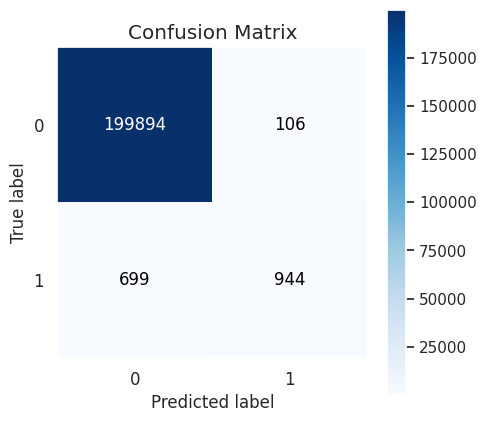

In [55]:
mt.plot_confusion_matrix(y_test,yhat_log, normalize = False, figsize = (5,5));

## 7.2. Support Vector Machine (SVM)

Support vector machine finds the best way to classify the data based on the position in relation to a border between positive class and negative class. 

In [56]:
# Model definition
svc = SVC()

# Model training
svc.fit(x_train, y_train)

# Model prediction 
yhat_svc = svc.predict( x_test );

#performance
result_svc = pd.DataFrame(["Support Vector Machine",accuracy_score(y_test,yhat_svc),
                           recall_score(y_test,yhat_svc), f1_score(y_test,yhat_svc),
                           precision_score(y_test,yhat_svc)]).T
result_svc.columns = ["Model",'Accuracy',"Recall","F1-Score","Precision_score"]

result_svc

,Model,Accuracy,Recall,F1-Score,Precision_score
0,Support Vector Machine,0.995,0.444,0.610,0.976


In [57]:
cm_vsc = confusion_matrix(y_test,yhat_svc)
print("Number of valid transactions labelled as fraudulent by Support Vector Machine : \n", cm_vsc[0,1])
print("Number of fraud transactions labelled as valid by Support Vector Machine : \n", cm_vsc[1,0])

Number of valid transactions labelled as fraudulent by Support Vector Machine : 
 18
Number of fraud transactions labelled as valid by Support Vector Machine : 
 914


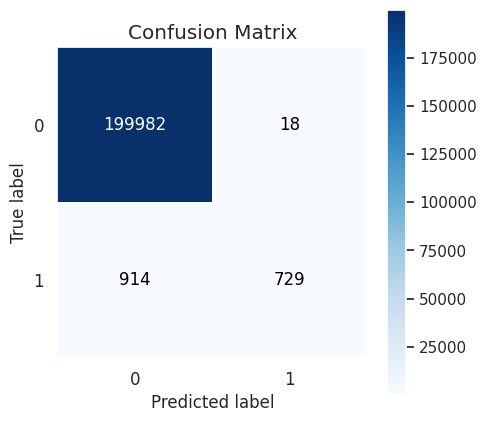

In [58]:
mt.plot_confusion_matrix(y_test,yhat_svc, normalize = False, figsize = (5,5));

## 7.3. Random Forest Classifier

A decision tree is a supervised learning algorithm that is perfect for classification problems, as it’s able to order classes on a precise level. It works like a flow chart, separating data points into two similar categories at a time from the “tree trunk” to “branches,” to “leaves,” where the categories become more finitely similar. This creates categories within categories, allowing for organic classification with limited human supervision.

In [59]:
# Model definition
rf = RandomForestClassifier(n_jobs = -1)

# Model training
rf.fit(x_train, y_train)

# Model Prediction
yhat_rf = rf.predict(x_test)

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Recall","F1-Score","Precision_score"]

result_rf

,Model,Accuracy,Recall,F1-Score,Precision_score
0,Random Forest Classifier,1.000,0.994,0.997,1.000


In [60]:
cm_rf = confusion_matrix(y_test,yhat_rf)
print("Number of valid transactions labelled as fraudulent by Random Forest: \n", cm_rf[0,1])
print("Number of fraud transactions labelled as valid by Random Forest: \n", cm_rf[1,0])

Number of valid transactions labelled as fraudulent by Random Forest: 
 0
Number of fraud transactions labelled as valid by Random Forest: 
 10


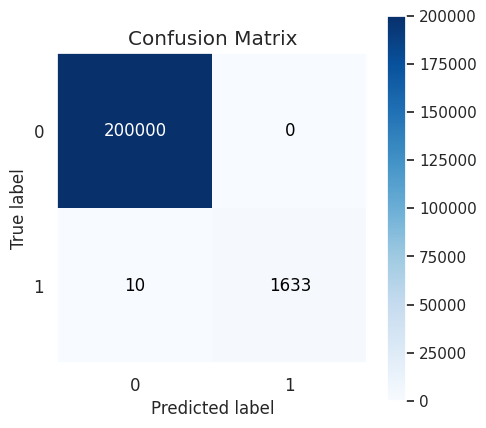

In [61]:
mt.plot_confusion_matrix(y_test,yhat_rf, normalize = False, figsize = (5,5));


# 8. BUSINESS PERFORMANCE


First of all, let's remember what is the business model:

**1** - The company receives 20% of each transaction value truly detected as fraud.

**2** - The company receives 5% of each transaction value detected as fraud, however the transaction is legal.

**3** - The company pays back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraudulent.


What do we need to show?

*    What is the model's Precision and Recall?
*    What is the Expected Billing by the Company if we classify 100% of transactions with the model?



In [62]:
x_test['is_fraud'] = y_test

# Join predictions on the test set in order to calculate the business performance
x_test['predictions'] = yhat_rf

# Revert rescaling
x_test['amount'] = rs_amount.inverse_transform(x_test[['amount']])

In [63]:
# The company receives 20% of each transaction value truly detected as fraud
fraud_detected = x_test[(x_test['is_fraud'] == 1) & (x_test['predictions'] == 1)]
fraud_detected_amount = fraud_detected[['amount', 'is_fraud', 'predictions']].\
                                                groupby(['is_fraud', 'predictions']).sum().reset_index()
fraud_detected_amount['to_receive'] = fraud_detected_amount['amount']*0.2
fraud_detected_amount

,is_fraud,predictions,amount,to_receive
0,1,1,2190434654.230,438086930.846


In [64]:
# The company receives 5% of each transaction value detected as fraud, however the transaction is legal
fraud_detected_leg = x_test[(x_test['is_fraud'] == 0) & (x_test['predictions'] == 1)]
fraud_detected_leg_amount = fraud_detected_leg[['amount', 'is_fraud', 'predictions']].\
                                                groupby(['is_fraud', 'predictions']).sum().reset_index()
fraud_detected_leg_amount['to_receive'] = fraud_detected_leg_amount['amount']*0.05
fraud_detected_leg_amount

,is_fraud,predictions,amount,to_receive


In [65]:
# The company pays back 100% of the value for the customer in each transaction detected as legitimate,
# however the transaction is actually a fraudulent

fraud_not_detected = x_test[(x_test['is_fraud'] == 1) & (x_test['predictions'] == 0)]
fraud_not_detected_amount = fraud_not_detected[['amount', 'is_fraud', 'predictions']].\
                                                groupby(['is_fraud', 'predictions']).sum().reset_index()
fraud_not_detected_amount

,is_fraud,predictions,amount
0,1,0,2688507.920


In [67]:
# results
print('Detectify will receive ${:,.2f} due to transactions truly detected as fraud'.\
      format(fraud_detected_amount['to_receive'][0]))

# print('Detectify will receive ${:,.2f} due to transactions detected as fraud, but actually legal'.\
#       format(fraud_detected_leg_amount['to_receive'][0]))

print('Detectify will pay ${:,.2f} due to transactions considered legal, but actually fraudulent'.\
      format(fraud_not_detected_amount['amount'][0]))

Detectify will receive $438,086,930.85 due to transactions truly detected as fraud
Detectify will pay $2,688,507.92 due to transactions considered legal, but actually fraudulent


## 8.1. Model Performance Results

In [68]:
print('Model Accuracy : {:,.3f}% '.format(accuracy_score(y_test,yhat_rf)*100))
print('Model Precision : {:,.3f}% '.format(precision_score(y_test,yhat_rf)*100))
print('Model Recall : {:,.3f}% '.format(recall_score(y_test,yhat_rf)*100))

Model Accuracy : 99.995% 
Model Precision : 100.000% 
Model Recall : 99.391% 


The model has a precision of 99.94%. From all transactions classified as fraudulent, only %0.06 were not.

The model has a recall of 99.39%. Detectify is able to dectect %99.39 of all fraudulent transactions.

The model accuracy is 99.995%. The accuracy is not recommended to be used as a business metric. Even if the model guess that 100% of transactions are legal, it would still be 99.92% accurate. Only 0.08% of all transactions are fraudulent. 

2nd cycle: check how balance error is related to fraud

Consider a deeper EDA

Cross-Validation: consider doing a cross validation 

Hyper parameter fine tuning. Ajust the ML model

Deploy the ML model to the cloud. So anyone can send data and receive a prediction of fraud through an API request
